In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [49]:
def mape(y_true, y_pred):
    n = len(y_true)
    mape = sum(np.abs((y_true - y_pred)/y_true))/n*100
    return mape

In [2]:
def readTrain():
  train = pd.read_csv("SPY.csv")
  return train

In [3]:
#除了基本資料提供的Features(Open, High, Low, Close, Adj Close, Volume)以外，還可自己增加Features，例如星期幾、幾月、幾號等等。

def augFeatures(train):
  train["Date"] = pd.to_datetime(train["Date"])
  train["year"] = train["Date"].dt.year
  train["month"] = train["Date"].dt.month
  train["date"] = train["Date"].dt.day
  train["day"] = train["Date"].dt.dayofweek
  return train

In [4]:
#將所有資料做正規化，而由於Date 是字串非數字，因此先將它drop掉
def normalize(train):
  train = train.drop(["Date"], axis=1)
  train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
  return train_norm

In [5]:
# 輸入X_train: 利用前30天的Open, High, Low, Close, Adj Close, Volume, month, year, date, day作為Features，shape為(30, 10)
# 輸出Y_train: 利用未來5天的Adj Close作為Features，shape為(5,1)
# https://miro.medium.com/max/1099/1*QUwzqa1Gi0bGbsIDQqpOhw.png
def buildTrain(train, pastDay=30, futureDay=5): # 30 1
  X_train, Y_train = [], []
  for i in range(train.shape[0]-futureDay-pastDay):
    X_train.append(np.array(train.iloc[i:i+pastDay]))  #0~29
    Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["Adj Close"])) #30:31=30
  return np.array(X_train), np.array(Y_train)

In [6]:
#將資料打散，而非照日期排序
'''
np.random.shuffle(train)的含义就是将所有训练数据随机打乱，这样在训练的时候每次喂给模型的数据的概率分布是均匀的。
简单来说，如果不打乱的数据的话，在连续的训练过程中，很容易让模型的weights空间陷入局部最优，打乱这些数据能够更好的让模型的参数优化过程更好
更稳（更多解释见：https://datascience.stackexchange.com/questions/24511/why-should-the-data-be-shuffled-for-machine-learning）。
'''
def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [7]:
#將Training Data取一部份當作Validation Data
def splitData(X,Y,rate):
  X_train = X[int(X.shape[0]*rate):]
  Y_train = Y[int(Y.shape[0]*rate):]
  X_val = X[:int(X.shape[0]*rate)]
  Y_val = Y[:int(Y.shape[0]*rate)]
  return X_train, Y_train, X_val, Y_val

In [8]:
# read SPY.csv
train = readTrain()

# Augment the features (year, month, date, day)
train_Aug = augFeatures(train)

# Normalization
train_norm = normalize(train_Aug)

# build Data, use last 30 days to predict next 5 days
X_train, Y_train = buildTrain(train_norm, 30, 5)

# shuffle the data, and random seed is 10
X_train, Y_train = shuffle(X_train, Y_train)

# split training data and validation data
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
# X_trian: (5710, 30, 10)
# Y_train: (5710, 5, 1)
# X_val: (634, 30, 10)
# Y_val: (634, 5, 1)

In [10]:
X_val.shape

(631, 30, 10)

In [61]:
#一對一模型
#由於是一對一模型，因此return_sequences 也可設為False ，但Y_train 以及Y_val的維度需改為二維(5710,1)以及(634,1) 。

def buildOneToOneModel(shape):
  model = Sequential()
  #return_sequences：默认 False。在输出序列中，返回单个 hidden state值还是返回全部 time step 的 hidden state值。 False 返回单个， true 返回全部。
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (1, 1)
  model.add(TimeDistributed(Dense(1)))    # or use model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [62]:
#將過去的天數pastDay設為1，預測的天數futureDay也設為1，用第二天的結果作為第一天x的y
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 1)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)



# from 2 dimmension to 3 dimension 因為過去的天數pastDay設為1,所以y是2維，要變成3維
Y_train = Y_train[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]

model = buildOneToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

d:\python\lib\site-packages\ipykernel_launcher.py:7: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  import sys
d:\python\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=True, input_shape=(1, 10))`
  import sys


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 1, 10)             840       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 1)              11        
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Train on 5710 samples, validate on 634 samples
Epoch 1/1000
5710/5710 [==============================] - 0s 48us/step - loss: 0.0308 - val_loss: 0.0170
Epoch 2/1000
5710/5710 [==============================] - 0s 10us/step - loss: 0.0101 - val_loss: 0.0038
Epoch 3/1000
5710/5710 [==============================] - 0s 8us/step - loss: 0.0018 - val_loss: 5.0812e-04
Epoch 4/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.5885e-04 - val_loss: 2.2822e-04
Epoch 5/1000
5710/5710 [=================

Epoch 68/1000
5710/5710 [==============================] - 0s 9us/step - loss: 3.9358e-05 - val_loss: 4.5050e-05
Epoch 69/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.9559e-05 - val_loss: 4.1453e-05
Epoch 70/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.8721e-05 - val_loss: 4.2090e-05
Epoch 71/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.8333e-05 - val_loss: 4.2137e-05
Epoch 72/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.8291e-05 - val_loss: 4.0995e-05
Epoch 73/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.7923e-05 - val_loss: 3.9785e-05
Epoch 74/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.7241e-05 - val_loss: 3.9499e-05
Epoch 75/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.6941e-05 - val_loss: 3.9086e-05
Epoch 76/1000
5710/5710 [==============================] - 0s 8us/step - loss: 3.6816e-05 - val_

5710/5710 [==============================] - 0s 8us/step - loss: 2.3859e-05 - val_loss: 2.3404e-05
Epoch 141/1000
5710/5710 [==============================] - 0s 8us/step - loss: 2.3930e-05 - val_loss: 2.2473e-05
Epoch 142/1000
5710/5710 [==============================] - 0s 9us/step - loss: 2.3712e-05 - val_loss: 2.3097e-05
Epoch 143/1000
5710/5710 [==============================] - 0s 9us/step - loss: 2.3588e-05 - val_loss: 2.2987e-05
Epoch 144/1000
5710/5710 [==============================] - 0s 8us/step - loss: 2.3393e-05 - val_loss: 2.2172e-05
Epoch 145/1000
5710/5710 [==============================] - 0s 9us/step - loss: 2.3398e-05 - val_loss: 2.2332e-05
Epoch 146/1000
5710/5710 [==============================] - 0s 9us/step - loss: 2.3634e-05 - val_loss: 2.2523e-05
Epoch 147/1000
5710/5710 [==============================] - 0s 9us/step - loss: 2.3434e-05 - val_loss: 2.2326e-05
Epoch 148/1000
5710/5710 [==============================] - 0s 8us/step - loss: 2.4415e-05 - val_loss: 

In [63]:
from sklearn.metrics import r2_score

predicted_stock_price = model.predict(X_val)
Y_val_one=np.reshape(Y_val,(Y_val.shape[0]*Y_val.shape[1]))
predicted_stock_price_one=np.reshape(predicted_stock_price,(Y_val.shape[0]*Y_val.shape[1]))
print("R2:", r2_score(Y_val_one, predicted_stock_price_one))
print("MAPE:",mape(Y_val_one, predicted_stock_price_one))

R2: 0.999522391862988
MAPE: 8.636939333603392


In [70]:
train_Aug

,Date,Open,High,Low,Close,Adj Close,Volume,year,month,date,day
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,26.583992,1003200,1993,1,29,4
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,26.773048,480500,1993,2,1,0
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.829773,201300,1993,2,2,1
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,27.113388,529400,1993,2,3,2
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,27.226835,531500,1993,2,4,3
...,...,...,...,...,...,...,...,...,...,...,...
6341,2018-04-05,265.549988,266.640015,264.320007,265.640015,258.131256,82652600,2018,4,5,3
6342,2018-04-06,263.420013,265.109985,258.000000,259.720001,252.378555,179521200,2018,4,6,4
6343,2018-04-09,261.369995,264.839996,259.940002,261.000000,253.622391,105442900,2018,4,9,0
6344,2018-04-10,264.269989,266.040009,262.980011,265.149994,257.655121,103529000,2018,4,10,1


In [67]:
#多對一模型
#LSTM參數return_sequences=False ，未設定時default也為False，而且不可使用TimeDistribution
#return_sequence=True 就可以用 TimeDistribution
#return_sequences=True 假設取前30天的x預測y，return_sequences=True就是每天的預測結果作為x輸入到下一天，但是y只有1，所以要再接一層 False

def buildManyToOneModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True)) #原來為False
  # output shape: (1, 1)
  model.add(LSTM(20, return_sequences=False)) #原多加一層false
  model.add(Dense(1))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [68]:
#需要設定的有pastDay=30、future=1 ，且注意Y_train 的維度需為二維
train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 30, 1)
X_train, Y_train = shuffle(X_train, Y_train)
# because no return sequence, Y_train and Y_val shape must be 2 dimension
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

model = buildManyToOneModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

d:\python\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\python\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=True, input_shape=(30, 10))`
  


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 10)            840       
_________________________________________________________________
lstm_14 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 21        
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
_________________________________________________________________
Train on 5684 samples, validate on 631 samples
Epoch 1/1000
5684/5684 [==============================] - 1s 216us/step - loss: 0.0042 - val_loss: 6.1573e-04
Epoch 2/1000
5684/5684 [==============================] - 1s 123us/step - loss: 4.0594e-04 - val_loss: 3.0058e-04
Epoch 3/1000
5684/5684 [==============================] - 1s 123us/step - loss: 2.3155e-04 - val_loss: 2.2279e

5684/5684 [==============================] - 1s 126us/step - loss: 5.0859e-05 - val_loss: 5.8628e-05
Epoch 66/1000
5684/5684 [==============================] - 1s 129us/step - loss: 5.2613e-05 - val_loss: 6.3183e-05
Epoch 67/1000
5684/5684 [==============================] - 1s 129us/step - loss: 4.9825e-05 - val_loss: 5.7143e-05
Epoch 68/1000
5684/5684 [==============================] - 1s 129us/step - loss: 4.9723e-05 - val_loss: 5.7820e-05
Epoch 69/1000
5684/5684 [==============================] - 1s 125us/step - loss: 5.0915e-05 - val_loss: 5.4700e-05
Epoch 70/1000
5684/5684 [==============================] - 1s 129us/step - loss: 4.6762e-05 - val_loss: 5.6010e-05
Epoch 71/1000
5684/5684 [==============================] - 1s 125us/step - loss: 4.9963e-05 - val_loss: 5.6524e-05
Epoch 72/1000
5684/5684 [==============================] - 1s 123us/step - loss: 4.8937e-05 - val_loss: 5.7373e-05
Epoch 73/1000
5684/5684 [==============================] - 1s 125us/step - loss: 4.7211e-05 - 

5684/5684 [==============================] - 1s 121us/step - loss: 3.2600e-05 - val_loss: 3.7176e-05
Epoch 137/1000
5684/5684 [==============================] - 1s 127us/step - loss: 3.3774e-05 - val_loss: 3.6498e-05
Epoch 138/1000
5684/5684 [==============================] - 1s 122us/step - loss: 3.2423e-05 - val_loss: 3.6104e-05
Epoch 139/1000
5684/5684 [==============================] - 1s 132us/step - loss: 3.4313e-05 - val_loss: 3.6234e-05
Epoch 140/1000
5684/5684 [==============================] - 1s 132us/step - loss: 3.3276e-05 - val_loss: 3.7989e-05
Epoch 141/1000
5684/5684 [==============================] - 1s 127us/step - loss: 3.3868e-05 - val_loss: 4.6600e-05
Epoch 142/1000
5684/5684 [==============================] - 1s 128us/step - loss: 3.5658e-05 - val_loss: 3.5576e-05
Epoch 143/1000
5684/5684 [==============================] - 1s 145us/step - loss: 3.1982e-05 - val_loss: 3.5405e-05
Epoch 144/1000
5684/5684 [==============================] - 1s 140us/step - loss: 3.168

In [69]:
from sklearn.metrics import r2_score

predicted_stock_price = model.predict(X_val)
Y_val_one=np.reshape(Y_val,(Y_val.shape[0]*Y_val.shape[1]))
predicted_stock_price_one=np.reshape(predicted_stock_price,(Y_val.shape[0]*Y_val.shape[1]))
print("R2:", r2_score(Y_val_one, predicted_stock_price_one))
print("MAPE:",mape(Y_val_one, predicted_stock_price_one))

R2: 0.9993053269384985
MAPE: 11.373859810261866


In [55]:
#一對多模型
#因為是一對多模型Timesteps只有1，因此return_sequences=False 才可執行
def buildOneToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=False))
  # output shape: (5, 1)
  model.add(Dense(1))
    # 1對5的模型
  model.add(RepeatVector(5))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [56]:
# 將pastDay 設為1, futureDay 設為5


train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildOneToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])


d:\python\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
d:\python\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=False, input_shape=(1, 10))`
  """


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 5, 1)              0         
Total params: 851
Trainable params: 851
Non-trainable params: 0
_________________________________________________________________
Train on 5706 samples, validate on 634 samples
Epoch 1/1000
5706/5706 [==============================] - 0s 45us/step - loss: 0.0150 - val_loss: 0.0078
Epoch 2/1000
5706/5706 [==============================] - 0s 9us/step - loss: 0.0037 - val_loss: 8.5258e-04
Epoch 3/1000
5706/5706 [==============================] - 0s 9us/step - loss: 3.5133e-04 - val_loss: 1.8136e-04
Epoch 4/1000
5

5706/5706 [==============================] - 0s 10us/step - loss: 6.5185e-05 - val_loss: 6.2813e-05
Epoch 67/1000
5706/5706 [==============================] - 0s 9us/step - loss: 6.4645e-05 - val_loss: 6.2496e-05
Epoch 68/1000
5706/5706 [==============================] - 0s 12us/step - loss: 6.4418e-05 - val_loss: 6.2432e-05
Epoch 69/1000
5706/5706 [==============================] - 0s 9us/step - loss: 6.3467e-05 - val_loss: 6.1800e-05
Epoch 70/1000
5706/5706 [==============================] - 0s 13us/step - loss: 6.3807e-05 - val_loss: 6.1206e-05
Epoch 71/1000
5706/5706 [==============================] - 0s 11us/step - loss: 6.3607e-05 - val_loss: 6.0564e-05
Epoch 72/1000
5706/5706 [==============================] - 0s 9us/step - loss: 6.2398e-05 - val_loss: 6.1285e-05
Epoch 73/1000
5706/5706 [==============================] - 0s 14us/step - loss: 6.2217e-05 - val_loss: 6.0534e-05
Epoch 74/1000
5706/5706 [==============================] - 0s 13us/step - loss: 6.1695e-05 - val_loss: 6.

In [57]:
from sklearn.metrics import r2_score
predicted_stock_price = model.predict(X_val)
Y_val_one=np.reshape(Y_val,(Y_val.shape[0]*Y_val.shape[1]*Y_val.shape[2]))
predicted_stock_price_one=np.reshape(predicted_stock_price,(Y_val.shape[0]*Y_val.shape[1]*Y_val.shape[2]))

print("R2:", r2_score(Y_val_one, predicted_stock_price_one))
print("MAPE:",mape(Y_val_one, predicted_stock_price_one))

R2: 0.998819436227046
MAPE: 47.35720628641495


In [189]:
# 多對多模型 (輸入與輸出相同長度)
# 將return_sequences 設為True ，再用TimeDistributed(Dense(1)) 將輸出調整為(5,1)

def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2], return_sequences=True))
  # output shape: (5, 1)
  model.add(LSTM(20, return_sequences=True))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

In [190]:
# 將pastDay 以及futureDay 設為相同長度10

train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 5, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# # from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

d:\python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\python\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=True, input_shape=(5, 10))`
  


Model: "sequential_60"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_98 (LSTM)               (None, 5, 10)             840       
_________________________________________________________________
lstm_99 (LSTM)               (None, 5, 20)             2480      
_________________________________________________________________
time_distributed_28 (TimeDis (None, 5, 1)              21        
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
_________________________________________________________________
Train on 5703 samples, validate on 633 samples
Epoch 1/1000
5703/5703 [==============================] - 1s 113us/step - loss: 0.0267 - val_loss: 0.0128
Epoch 2/1000
5703/5703 [==============================] - 0s 39us/step - loss: 0.0123 - val_loss: 0.0100
Epoch 3/1000
5703/5703 [==============================] - 0s 35us/step - loss: 0.0092 - val_loss: 0.0069
Epoch 4/1000
5703/

5703/5703 [==============================] - 0s 32us/step - loss: 9.8088e-05 - val_loss: 1.0355e-04
Epoch 67/1000
5703/5703 [==============================] - 0s 35us/step - loss: 9.6022e-05 - val_loss: 9.6601e-05
Epoch 68/1000
5703/5703 [==============================] - 0s 34us/step - loss: 9.7314e-05 - val_loss: 9.9645e-05
Epoch 69/1000
5703/5703 [==============================] - 0s 36us/step - loss: 9.7991e-05 - val_loss: 9.7439e-05
Epoch 70/1000
5703/5703 [==============================] - 0s 35us/step - loss: 9.3644e-05 - val_loss: 9.7947e-05
Epoch 71/1000
5703/5703 [==============================] - 0s 34us/step - loss: 9.6167e-05 - val_loss: 9.9316e-05
Epoch 72/1000
5703/5703 [==============================] - 0s 35us/step - loss: 9.4257e-05 - val_loss: 1.0299e-04
Epoch 73/1000
5703/5703 [==============================] - 0s 35us/step - loss: 9.4806e-05 - val_loss: 9.8260e-05
Epoch 74/1000
5703/5703 [==============================] - 0s 38us/step - loss: 9.8621e-05 - val_loss:

In [191]:
from sklearn.metrics import r2_score
predicted_stock_price = model.predict(X_val)
Y_val_one=np.reshape(Y_val,(Y_val.shape[0]*Y_val.shape[1]))
predicted_stock_price_one=np.reshape(predicted_stock_price,(Y_val.shape[0]*Y_val.shape[1]))

print("R2:", r2_score(Y_val_one, predicted_stock_price_one))
print("MAPE:",mape(Y_val_one, predicted_stock_price_one))

R2: 0.9978333037108332
MAPE: 29.681770149620096


In [163]:
# 多對多模型 (輸入與輸出不相同長度)
# 先用return_sequences計算
# 再用RepeatVector重复向量层，多次重复所提出的2D输入以创建3D输出
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=True))
  # output shape: (5, 1)
  model.add(LSTM(20, return_sequences=False))
    # 1對5的模型
  model.add(RepeatVector(5))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

# model.add(RepeatVector(5))

In [171]:
# 多對多模型 (輸入與輸出不相同長度)
# Encoder-Decoder LSTM 先RepeatVector重复向量层，多次重复所提出的2D输入以创建3D输出
# 再用return_sequences計算
# 总的来说，使用RepeatVector作为编码器的固定大小的2D输出，以适应解码器期望的不同长度和3D输入。
# TimeDistributed wrapper允许相同的输出层用于输出序列中的每个元素。
def buildManyToManyModel(shape):
  model = Sequential()
  model.add(LSTM(10, input_length=shape[1], input_dim=shape[2],return_sequences=False))
  model.add(RepeatVector(5))
# output shape: (5, 1)
  model.add(LSTM(20, return_sequences=True))
    # 1對5的模型
#   model.add(Dense(1))
  model.add(TimeDistributed(Dense(1)))
  model.compile(loss="mse", optimizer="adam")
  model.summary()
  return model

# model.add(RepeatVector(5))

In [108]:
X_train.shape

(5680, 30, 10)

In [172]:
# 將pastDay 以及futureDay 設為不相同長度

train = readTrain()
train_Aug = augFeatures(train)
train_norm = normalize(train_Aug)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 10, 5)
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

# # from 2 dimmension to 3 dimension
Y_train = Y_train[:,:,np.newaxis]
Y_val = Y_val[:,:,np.newaxis]

model = buildManyToManyModel(X_train.shape)
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

d:\python\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  
d:\python\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(10, return_sequences=False, input_shape=(10, 10))`
  


Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_88 (LSTM)               (None, 10)                840       
_________________________________________________________________
repeat_vector_18 (RepeatVect (None, 5, 10)             0         
_________________________________________________________________
lstm_89 (LSTM)               (None, 5, 20)             2480      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 5, 1)              21        
Total params: 3,341
Trainable params: 3,341
Non-trainable params: 0
_________________________________________________________________
Train on 5698 samples, validate on 633 samples
Epoch 1/1000
5698/5698 [==============================] - 1s 121us/step - loss: 0.0168 - val_loss: 0.0060
Epoch 2/1000
5698/5698 [==============================] - 0s 47us/step - loss: 0.0050 - val_loss

5698/5698 [==============================] - 0s 47us/step - loss: 6.6625e-05 - val_loss: 7.2640e-05
Epoch 66/1000
5698/5698 [==============================] - 0s 49us/step - loss: 6.7056e-05 - val_loss: 6.5593e-05
Epoch 67/1000
5698/5698 [==============================] - 0s 47us/step - loss: 6.8404e-05 - val_loss: 7.1434e-05
Epoch 68/1000
5698/5698 [==============================] - 0s 47us/step - loss: 6.6630e-05 - val_loss: 6.7098e-05
Epoch 69/1000
5698/5698 [==============================] - 0s 44us/step - loss: 6.8857e-05 - val_loss: 7.1162e-05
Epoch 70/1000
5698/5698 [==============================] - 0s 47us/step - loss: 6.8295e-05 - val_loss: 6.8516e-05
Epoch 71/1000
5698/5698 [==============================] - 0s 47us/step - loss: 6.6877e-05 - val_loss: 6.6325e-05
Epoch 72/1000
5698/5698 [==============================] - 0s 47us/step - loss: 7.0312e-05 - val_loss: 7.2654e-05
Epoch 73/1000
5698/5698 [==============================] - 0s 49us/step - loss: 6.6799e-05 - val_loss:

In [137]:
X_train.shape
# Y_val.shape

(5680, 30, 10)

In [173]:
from sklearn.metrics import r2_score
predicted_stock_price = model.predict(X_val)
Y_val_one=np.reshape(Y_val,(Y_val.shape[0]*Y_val.shape[1]))
predicted_stock_price_one=np.reshape(predicted_stock_price,(Y_val.shape[0]*Y_val.shape[1]))

print("R2:", r2_score(Y_val_one, predicted_stock_price_one))
print("MAPE:",mape(Y_val_one, predicted_stock_price_one))

R2: 0.9984562336875487
MAPE: 19.481556985771142


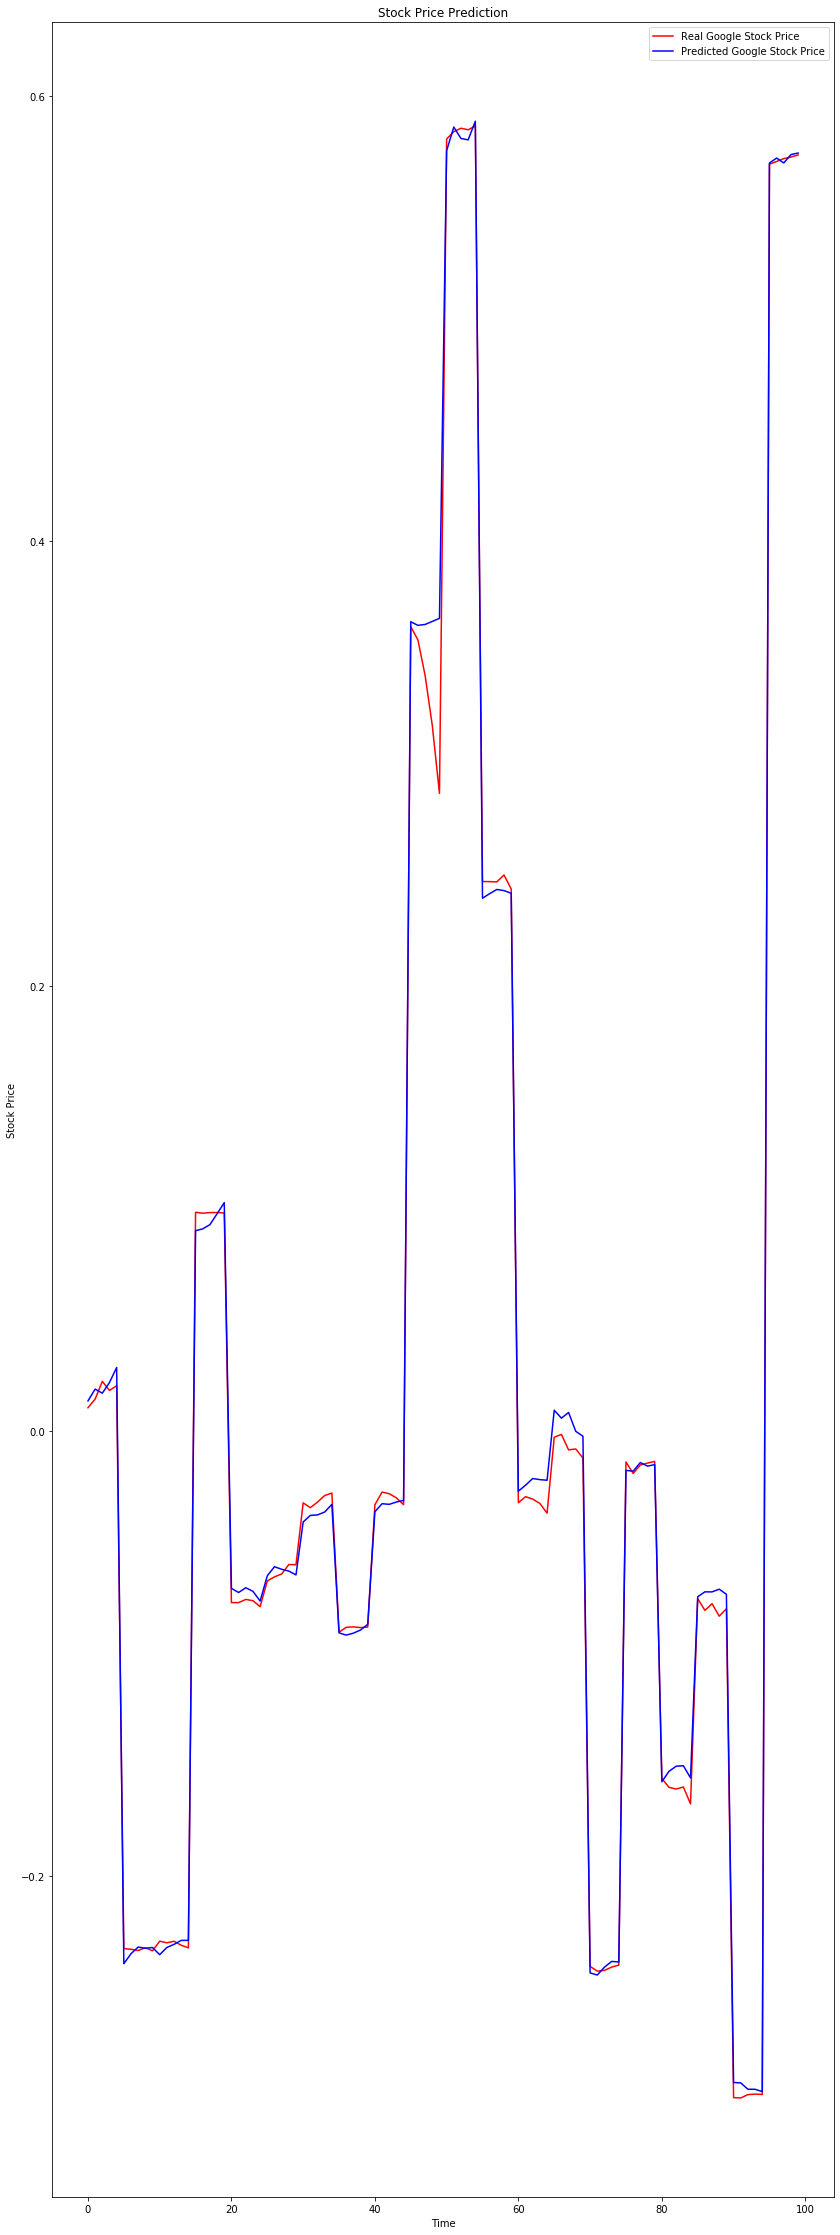

In [35]:

plt.figure(figsize=(14, 40))
plt.plot(Y_val_one[0:100], color = 'red', label = 'Real Google Stock Price')  # 紅線表示真實股價
plt.plot(predicted_stock_price_one[0:100], color = 'blue', label = 'Predicted Google Stock Price')  # 藍線表示預測股價
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()